In [1]:
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import re
from datetime import datetime
import numpy as np

Generating the urls for each US Congress

In [18]:
def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return suffix

senate_wikis = [
    'https://en.wikipedia.org/wiki/1st_United_States_Congress',
    'https://en.wikipedia.org/wiki/2nd_United_States_Congress',
    'https://en.wikipedia.org/wiki/3rd_United_States_Congress'
] + [f'https://en.wikipedia.org/wiki/{x}{ordinal(x)}_United_States_Congress' for x in range(4, 119)]
senate_wikis[:5]

['https://en.wikipedia.org/wiki/1st_United_States_Congress',
 'https://en.wikipedia.org/wiki/2nd_United_States_Congress',
 'https://en.wikipedia.org/wiki/3rd_United_States_Congress',
 'https://en.wikipedia.org/wiki/4th_United_States_Congress',
 'https://en.wikipedia.org/wiki/5th_United_States_Congress']

Loop over each url, and collect the start date of the congress and the table containing the list of senators

In [4]:
senate_tables = {}

# Regex for finding dates
r = re.compile("(Jan(uary)?|Feb(ruary)?|Mar(ch)?|Apr(il)?|May|Jun(e)?|"
    "Jul(y)?|Aug(ust)?|Sep(tember)?|Oct(ober)?|Nov(ember)?|"
    "Dec(ember)?)\s+\d{1,2},\s+\d{4}")

for url in senate_wikis:
    # ordinal indicator (1st, 2nd, etc.)
    congress = url.split('/')[-1].split('_')[0]
    
    # Find list of senators
    html = get(url).text
    soup = BeautifulSoup(html)
    # Isolate the members header
    members = soup.find_all('span', {'id': 'Members'})[0]
    # Isolate the next table that follows the header
    table = members.find_all_next('table')[0]
    senate_tables[congress] = {'senators': table}
    
    # Isolate start date
    summary_info = soup.find('table', {"class":'infobox vevent'}).text
    start_date = r.search(summary_info).group()
    start_date_dt = datetime.strptime(start_date, '%B %d, %Y')
    senate_tables[congress]['start_date'] = start_date_dt

Define a function that collects the wikipedia url for each senator, and isolates their birthday. The birthday is not organized in the html consistently, and some senators only have a birth year, so there is a lot of edge handling. 

In [10]:
def get_birthdays(table, cache):
    birthdays = {}
    for dd in table.find_all('dd'):
        a = dd.find('a')
        try:
            rel = a.attrs['href']
        except:
            continue
        if rel == '/wiki/Jonathan_Bourne':
            rel += '_Jr.'
        u = 'https://en.wikipedia.org' + rel
        
        if cache_value:= cache.get(u):
            bday = cache_value
            repeat = True
            
        else:
            repeat = False
            html = get(u).text
            soup = BeautifulSoup(html)
            try:
                bday = soup.find('span', {'class': 'bday'}).text
                bday = datetime.strptime(bday, '%Y-%m-%d')
            except ValueError:
                try:
                    bday = datetime.strptime(bday, '%Y-%m')
                except:
                    bday = datetime.strptime(bday, '%Y')
            except AttributeError:
                born = [x for x in soup.find_all('th') if x.text == 'Born']
                if born:
                    try:
                        bday = r.search(born[0].find_next('td').text).group()
                        bday = datetime.strptime(bday, '%B %d, %Y')
                    except AttributeError:
                        bday = re.findall('\d{4}', born[0].find_next('td').text)[0]
                        bday = datetime.strptime(bday, '%Y')
                else:
                    bday=None
            if rel in [
                '/wiki/William_Allen_(governor)',
                '/wiki/Weldon_B._Heyburn',
                '/wiki/Fred_Dubois',
                '/wiki/Isaac_D._Barnard'
            ]:
                born = [x for x in soup.find_all('th') if x.text == 'Born']
                bday = re.findall('\d{4}', born[0].find_next('td').text)[0]
                bday = datetime.strptime(bday, '%Y')
        if not repeat:    
            print(bday, u)
        birthdays[u] = bday
        cache[u] = bday
    return birthdays, cache

In [11]:
cache = {}
for key, val in senate_tables.items():
    print('==================================================================================')
    print(f'                                    {key}')
    print('==================================================================================')
    table = val['senators']
    birthdays, cache = get_birthdays(table, cache)
    senate_tables[key]['birthdays'] = birthdays

                                    1st
1745-04-29 00:00:00 https://en.wikipedia.org/wiki/Oliver_Ellsworth
1727-10-07 00:00:00 https://en.wikipedia.org/wiki/William_Samuel_Johnson
1733-09-18 00:00:00 https://en.wikipedia.org/wiki/George_Read_(signer)
1745-04-02 00:00:00 https://en.wikipedia.org/wiki/Richard_Bassett_(Delaware_politician)
1748-06-08 00:00:00 https://en.wikipedia.org/wiki/William_Few
1753-03-13 00:00:00 https://en.wikipedia.org/wiki/James_Gunn_(senator)
1737-09-19 00:00:00 https://en.wikipedia.org/wiki/Charles_Carroll_of_Carrollton
1750-11-01 00:00:00 https://en.wikipedia.org/wiki/John_Henry_(senator)
1738-05-28 00:00:00 https://en.wikipedia.org/wiki/Tristram_Dalton
1745-01-09 00:00:00 https://en.wikipedia.org/wiki/Caleb_Strong
1739-05-14 00:00:00 https://en.wikipedia.org/wiki/Paine_Wingate
1741-06-26 00:00:00 https://en.wikipedia.org/wiki/John_Langdon_(politician)
1745-11-29 00:00:00 https://en.wikipedia.org/wiki/Jonathan_Elmer
1745-12-24 00:00:00 https://en.wikipedia.or

Plotting the age distribution for each congress. It looks like there are some congresses with senators younger than 30, which is almost certainly incorrect. This should not impact median measurements, but probably worth looking into you, the reader, decide to use this dataset for anything else!

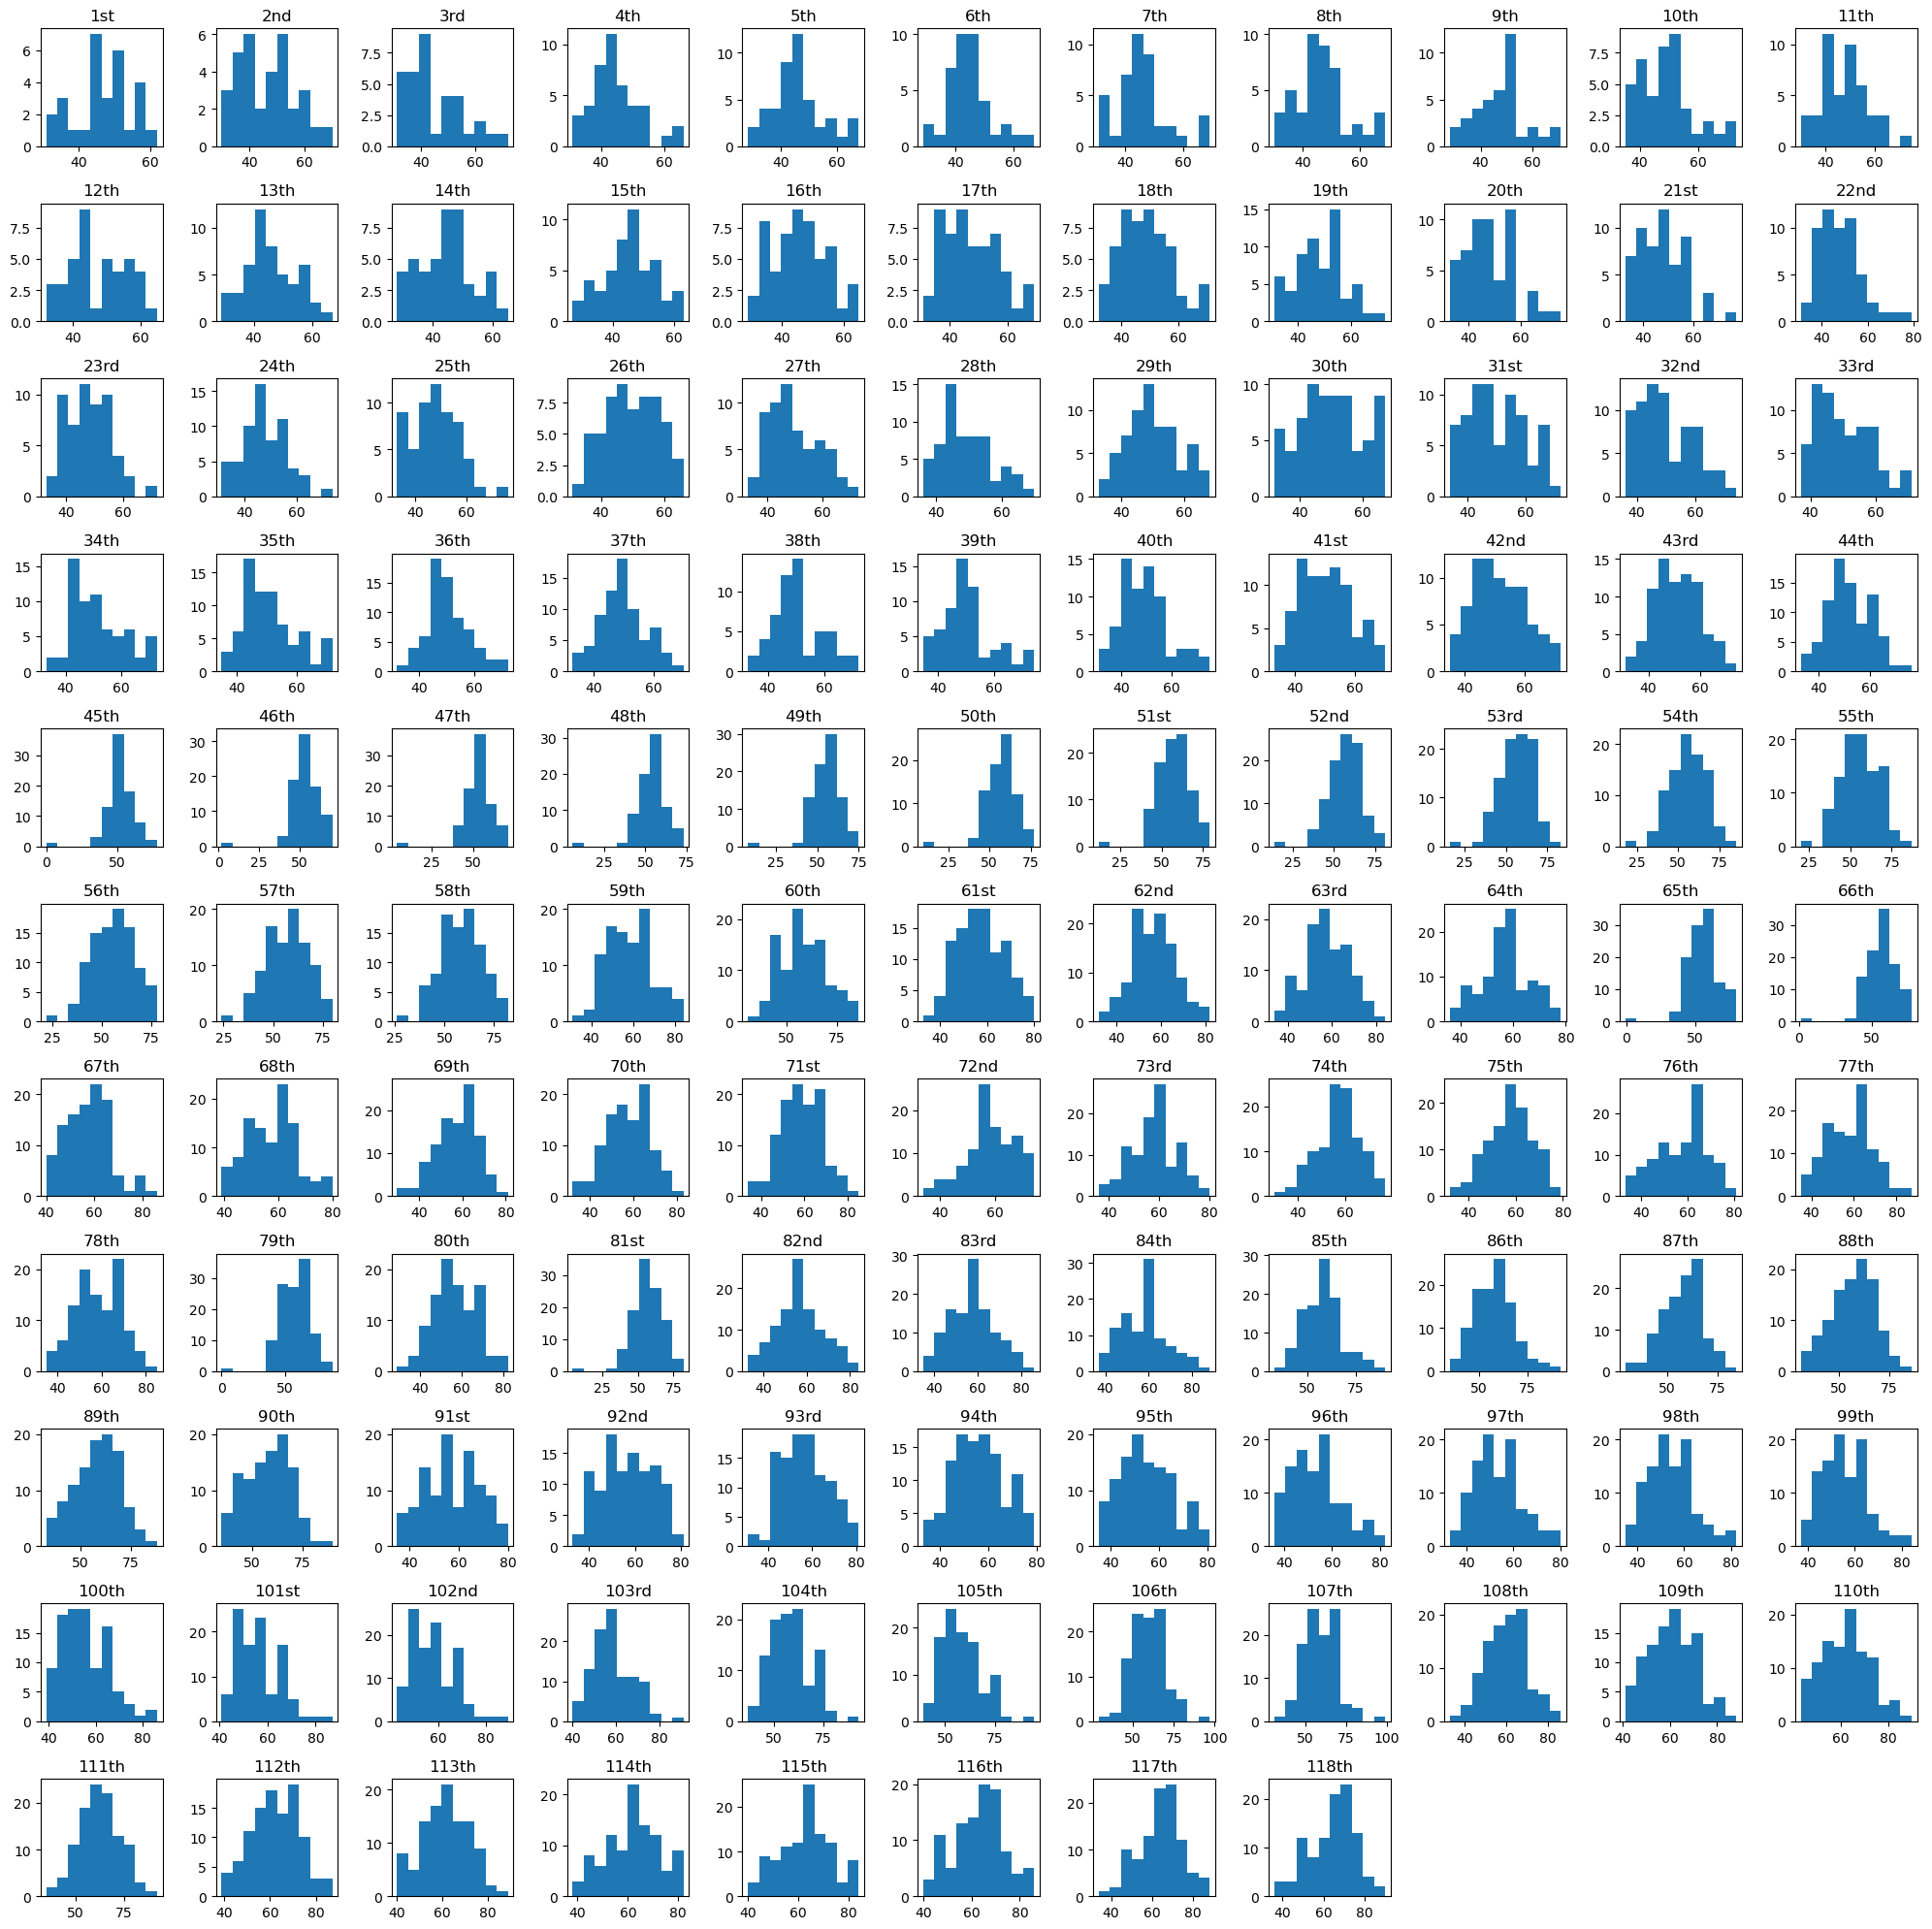

In [12]:
fig, axs = plt.subplots(11, 11, figsize=(20,20))
medians = {}
for ax, key in zip(axs.ravel(), senate_tables.keys()):
    birthdays = [x.year for x in senate_tables[key]['birthdays'].values() if x]
    start_date = senate_tables[key]['start_date'].year
    age = [start_date - birthdate for birthdate in birthdays]
    median = np.median(age)
    medians[start_date] = median
    ax.hist(age)
    ax.set_title(key)
    
axs.ravel()[-1].set_axis_off()
axs.ravel()[-2].set_axis_off()
axs.ravel()[-3].set_axis_off()
fig.tight_layout()

Plotting median age by year!

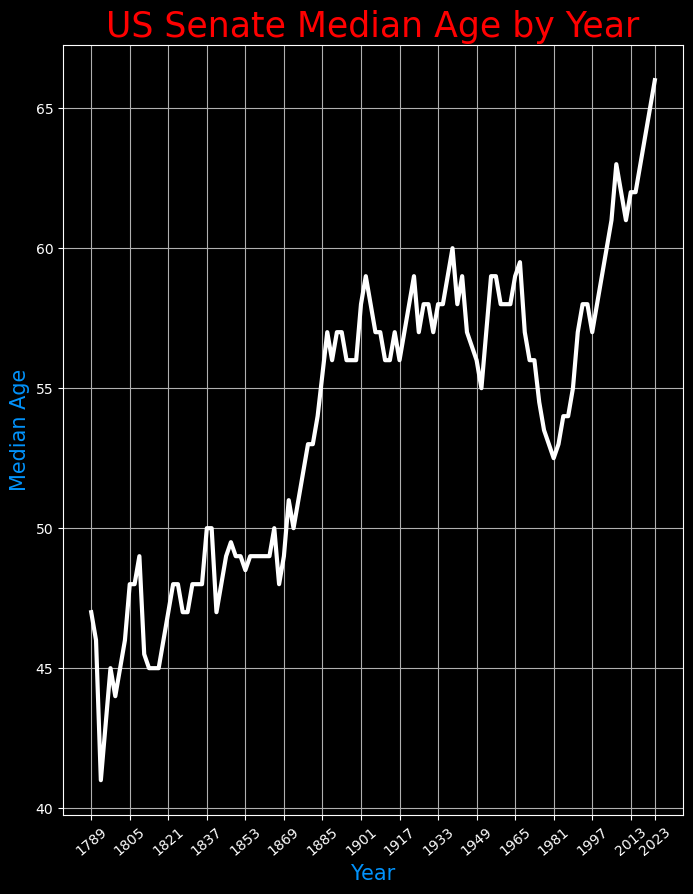

In [14]:
fig, ax = plt.subplots(figsize=(8,10), facecolor='black')
df = pd.DataFrame().assign(year=medians.keys(), age=medians.values())
df.plot(x='year', y='age', ax=ax, legend=False, linewidth=3, color='white')
ax.grid()
ax.set_xticks([val for idx, val in enumerate(df.year.tolist()) if idx%8 == 0] + [2023], fontsize=10, rotation=40)
ax.tick_params(axis='x', rotation=40)
ax.tick_params(colors='white')
ax.set_title('US Senate Median Age by Year', fontsize=25, color='red')
ax.set_xlabel('Year', fontsize=15, color='#0293fc')
ax.set_ylabel('Median Age', fontsize=15, color='#0293fc')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.set_facecolor('black')
fig.savefig('senate_yearly_median_age.png', dpi=360, facecolor='black')

Saving final dataset

In [16]:
data = []
for key, items in senate_tables.items():
    start_date = items['start_date']
    birthdays = items['birthdays']
    congress_data = [
        [key, start_date.strftime('%Y-%m-%d'), key_, val.strftime('%Y-%m-%d')] for key_, val in birthdays.items() if val
    ]
    data += congress_data
    
df = pd.DataFrame(data, columns=['congress', 'start_date', 'senator_url', 'senator_birthdate'])
df.head()

,congress,start_date,senator_url,senator_birthdate
0,1st,1789-03-04,https://en.wikipedia.org/wiki/Oliver_Ellsworth,1745-04-29
1,1st,1789-03-04,https://en.wikipedia.org/wiki/William_Samuel_J...,1727-10-07
2,1st,1789-03-04,https://en.wikipedia.org/wiki/George_Read_(sig...,1733-09-18
3,1st,1789-03-04,https://en.wikipedia.org/wiki/Richard_Bassett_...,1745-04-02
4,1st,1789-03-04,https://en.wikipedia.org/wiki/William_Few,1748-06-08


In [17]:
df.to_csv('senate_birthdays.csv', index=False)